In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [4]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation

In [5]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [6]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [7]:
def plot_autocorr_func(df_acorr_analysis):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title("Autocorrelation Function for Yt\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


In [8]:
filename = "02-table-04-sears-operating-revenue.ods"

df = read_ods(filename, {"Year": "t", "Yt": "Y_t"})
df.head()

,t,Y_t
0,1955,3307
1,1956,3556
2,1957,3601
3,1958,3721
4,1959,4036


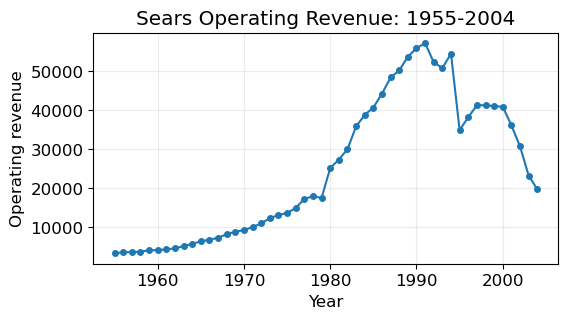

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Year")
ax.set_ylabel("Operating revenue")
ax.set_title("Sears Operating Revenue: 1955-2004")
ax.grid("on")
plt.show(fig)

In [10]:
num_of_rk = 10
df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "Y_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.961601,6.799542,49.064416,-0.284197,0.284197
1,2,0.919842,3.853231,94.895291,-0.479725,0.479725
2,3,0.872940,2.896452,137.049794,-0.605651,0.605651
3,4,0.812378,2.332415,174.351792,-0.699933,0.699933
4,5,0.750592,1.952980,206.903085,-0.772343,0.772343
5,6,0.689363,1.670742,234.984358,-0.829169,0.829169
6,7,0.623393,1.432974,258.482245,-0.874235,0.874235
7,8,0.549571,1.214393,277.179255,-0.909429,0.909429
8,9,0.468019,1.004970,291.069735,-0.935869,0.935869
9,10,0.382058,0.804302,300.557694,-0.954585,0.954585


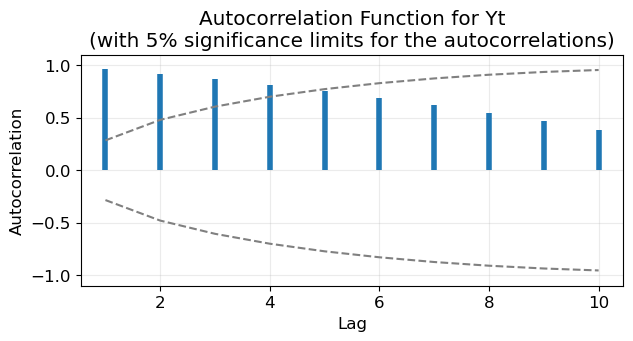

In [11]:
plot_autocorr_func(df_acorr_analysis)

In [12]:
df_diff = df.copy()
df_diff["Y_tM1"] = df_diff["Y_t"].shift(1)
df_diff["diff"] = df_diff["Y_t"] - df_diff["Y_tM1"]
df_diff = df_diff.drop(columns=["Y_t", "Y_tM1"])
df_diff = df_diff.rename(columns={"diff": "Y_t"})
df_diff.head()

,t,Y_t
0,1955,NaN
1,1956,249.0
2,1957,45.0
3,1958,120.0
4,1959,315.0


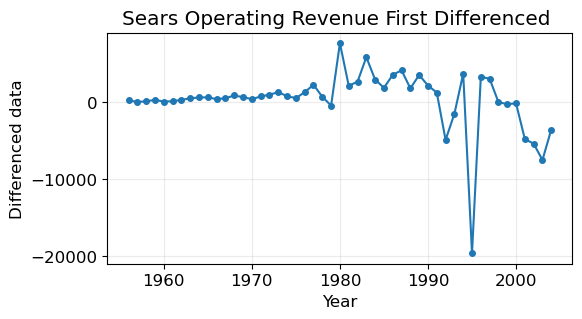

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_diff["t"], df_diff["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Year")
ax.set_ylabel("Differenced data")
ax.set_title("Sears Operating Revenue First Differenced ")
ax.grid("on")
plt.show(fig)


In [14]:
num_of_rk = 10
df_diff_acorr_analysis = get_correlogram(df_diff.dropna(), num_of_rk, columns=['t', "Y_t"])
df_diff_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.093467,0.654266,0.454818,-0.287234,0.287234
1,2,0.148351,1.029504,1.624993,-0.289732,0.289732
2,3,0.316708,2.151789,7.074120,-0.295933,0.295933
3,4,0.049511,0.308499,7.210251,-0.322687,0.322687
4,5,-0.025610,-0.159264,7.247502,-0.323313,0.323313
5,6,0.089635,0.557139,7.714434,-0.323480,0.323480
6,7,0.159533,0.985379,9.228765,-0.325523,0.325523
7,8,0.144327,0.874298,10.498396,-0.331911,0.331911
8,9,0.076160,0.454325,10.860772,-0.337049,0.337049
9,10,0.044129,0.262148,10.985555,-0.338466,0.338466


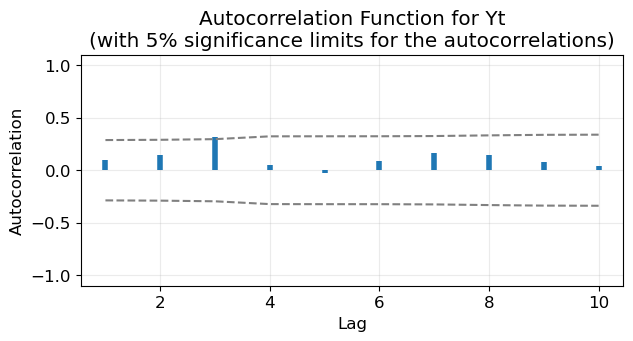

In [15]:
plot_autocorr_func(df_diff_acorr_analysis)
